In [1]:
%run utilities.ipynb 
load_standard_packages()
change_wordir()
from matplotlib.lines import Line2D
import itertools as it
from tqdm import tqdm
import math
from matplotlib import ticker
from modelbase.ode import Simulator
from scipy.optimize import minimize
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.58.0


In [27]:
analysis = "PAM"

colors, colours = colourblind_palette("own")

#model = "cyclic_2021"
#model = "cyclic_2021_ODE"
#model = "new_PSI"
#model = "new_PSII"
#model = "new_b6f"
model = "latest_dev"

m = load_model(model)


succesfully loaded latest_dev :D


In [28]:
# I like to have light as a derived variable
m.add_algebraic_module(module_name = "Light",
    function = lambda X, PFD: PFD, # X is not used
    compounds = ["PQ"], derived_compounds = ["L"], parameters = ['pfd'])

In [29]:
y0 = get_stst_y0(m, pfd =70) # pfd = 1200

# actual PAM

In [30]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    integrator_kwargs: Dict[str, Any] = None,
):
    if integrator_kwargs is None:
        integrator_kwargs = {}
    t = it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32)))
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)
    return s.get_full_results_df(), s.get_fluxes_df()


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s.simulation_parameters, s.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    return Fm, NPQ, tm, Fo, to

In [31]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("kcyc", 0.0)
s.clear_results()
c, v = pam_analysis(
    s,
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)

simulation:   0%|          | 0/40 [00:00<?, ?it/s]

simulation: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


In [32]:
Fm, NPQ, tm, Fo, to = get_npq(s)

NPQ_df = pd.DataFrame(
    {
        "NPQ": NPQ,
        "tm": tm,
    }
)

In [33]:
# c = checkpoint("c", f"{model}/{analysis}", "c", overwrite=True) # to recover original code quickly once changed
# v = checkpoint("v", f"{model}/{analysis}", "v", overwrite=True)

c = checkpoint("c", f"{model}/{analysis}", "c", overwrite=True) 
v = checkpoint("v", f"{model}/{analysis}", "v", overwrite=True)
NPQ_df = checkpoint("NPQ_df", f"{model}/{analysis}", "NPQ", overwrite=True)

Overwritten: data/latest_dev/PAM\c.joblib,  (backup created at data/latest_dev/PAM\backup_c.joblib)
Overwritten: data/latest_dev/PAM\v.joblib,  (backup created at data/latest_dev/PAM\backup_v.joblib)
Overwritten: data/latest_dev/PAM\NPQ.joblib,  (backup created at data/latest_dev/PAM\backup_NPQ.joblib)


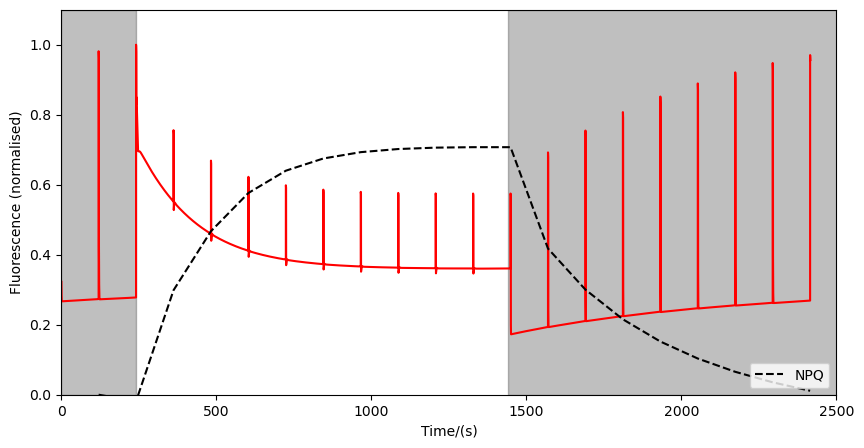

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 120, color=(0, 0, 0, 1 / 4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set(
    ylim=(0, 1.1),
    xlim=(0, 2500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)
ax.legend(loc="lower right")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

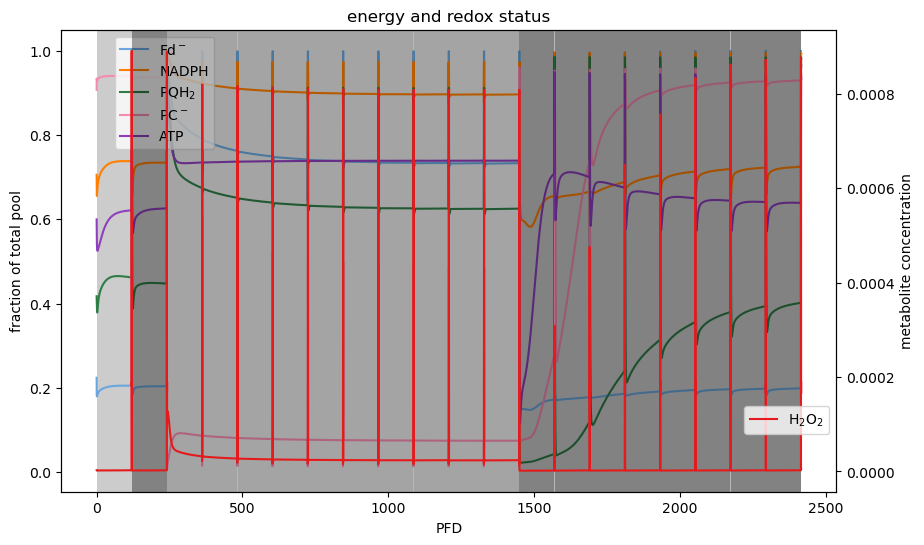

In [9]:
# ELECTRON CARRIERS

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(c["Fd_redoxstate"], label="Fd$^-$", color=colors[0])
ax1.plot(c["NADP_redoxstate"], label="NADPH", color=colors[1])
ax1.plot(c["PQ_redoxstate"], label="PQH$_2$", color=colors[2])
ax1.plot(c["PC_redoxstate"], label="PC$^-$", color=colors[3])
ax1.plot(c["ATP_norm"], label="ATP", color=colors[4])

ax2.plot(c["H2O2"], label="H$_2$O$_2$", color=colors[5])

# Set labels and legends
ax1.set(title="energy and redox status",
        xlabel="PFD",
        ylabel="fraction of total pool",
        #xlim=(450, 500)
        )
ax2.set_ylabel("metabolite concentration")

shade_light(c, (ax1, ax2))

# Legends
ax1.legend(loc="upper left", bbox_to_anchor=(0.06, 1))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))


In [ ]:
# outdated, pls refer to plot.ipynb

# compare multiple models

In [10]:
c_orig = checkpoint(".", f"cyclic_2021/{analysis}", filename="c")
v_orig = checkpoint(".", f"cyclic_2021/{analysis}", filename="v")

c_orig_ODE = checkpoint(".", f"cyclic_2021_ODE/{analysis}", filename="c")
v_orig_ODE = checkpoint(".", f"cyclic_2021_ODE/{analysis}", filename="v")

# c_PSI = checkpoint(".", f"new_PSI/{analysis}", filename="c")
# v_PSI = checkpoint(".", f"new_PSI/{analysis}", filename="v")

# c_new_PSs = checkpoint(".", f"new_PSII/{analysis}", filename="c")
# v_new_PSs = checkpoint(".", f"new_PSII/{analysis}", filename="v")

# c_new_b6f = checkpoint(".", f"new_b6f/{analysis}", filename="c")
# v_new_b6f = checkpoint(".", f"new_b6f/{analysis}", filename="v")

# c_latest = checkpoint(".", f"latest_dev/{analysis}", filename="c")
# v_latest = checkpoint(".", f"latest_dev/{analysis}", filename="v")

Loaded: data/cyclic_2021/PAM\c.joblib
Loaded: data/cyclic_2021/PAM\v.joblib
Loaded: data/cyclic_2021_ODE/PAM\c.joblib
Loaded: data/cyclic_2021_ODE/PAM\v.joblib


In [11]:
# data_var_name: ["linestyle", linewidth]
models = {
        "orig": ["-", 1],
        "orig_ODE": [":", 1],
        # "PSI": [((0, (0.5, 2))), 2],
        #"new_PSs": [":", 2],
        #"latest_60": ["-", 1],
        #"new_b6f": ["-", 1]
        }

Text(0, 0.5, 'metabolite concentration')

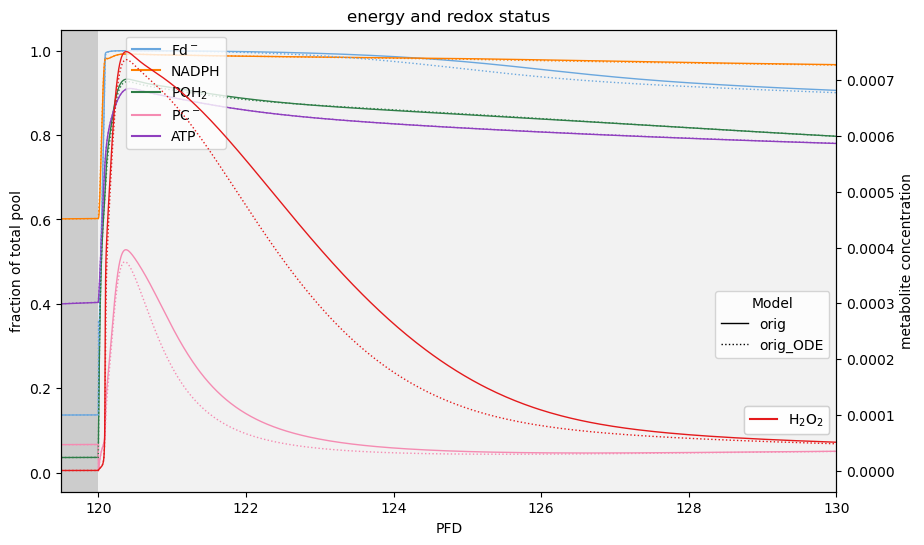

In [12]:
# ELECTRON CARRIERS

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name
        ax1.plot(c_model["Fd_redoxstate"], label="Fd$^-$", color=colors[0], linestyle=style, linewidth=width)
        ax1.plot(c_model["NADP_redoxstate"], label="NADPH", color=colors[1], linestyle=style, linewidth=width)
        ax1.plot(c_model["PQ_redoxstate"], label="PQH$_2$", color=colors[2], linestyle=style, linewidth=width)
        ax1.plot(c_model["PC_redoxstate"], label="PC$^-$", color=colors[3], linestyle=style, linewidth=width)
        ax1.plot(c_model["ATP_norm"], label="ATP", color=colors[4], linestyle=style, linewidth=width)

        ax2.plot(c_model["H2O2"], label="H$_2$O$_2$", color=colors[5], linestyle=style, linewidth=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

shade_light(c_model, (ax1))

# Legends

metabolite_handles1 = [
        Line2D([0], [0], label="Fd$^-$", color=colors[0]),
        Line2D([0], [0], label="NADPH", color=colors[1]),
        Line2D([0], [0], label="PQH$_2$", color=colors[2]),
        Line2D([0], [0], label="PC$^-$", color=colors[3]),
        Line2D([0], [0], label="ATP", color=colors[4])
]
metabolite_handles2 = [
        Line2D([0], [0], label="H$_2$O$_2$", color=colors[5])
]

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0.075, 1))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1, 0.2))
legend3 = ax1.legend(handles=model_handles,       title="Model")
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.legend(handles=model_handles, title="Model", loc="upper right", bbox_to_anchor=(1, 0.45))

# Set labels and legends
ax1.set(title="energy and redox status",
        xlabel="time(s)",
        ylabel="fraction of total pool",
        #xlim=(0, c_model.index[-1]),
        xlim=(119.5, 130)
        )
ax2.set_ylabel("metabolite concentration")


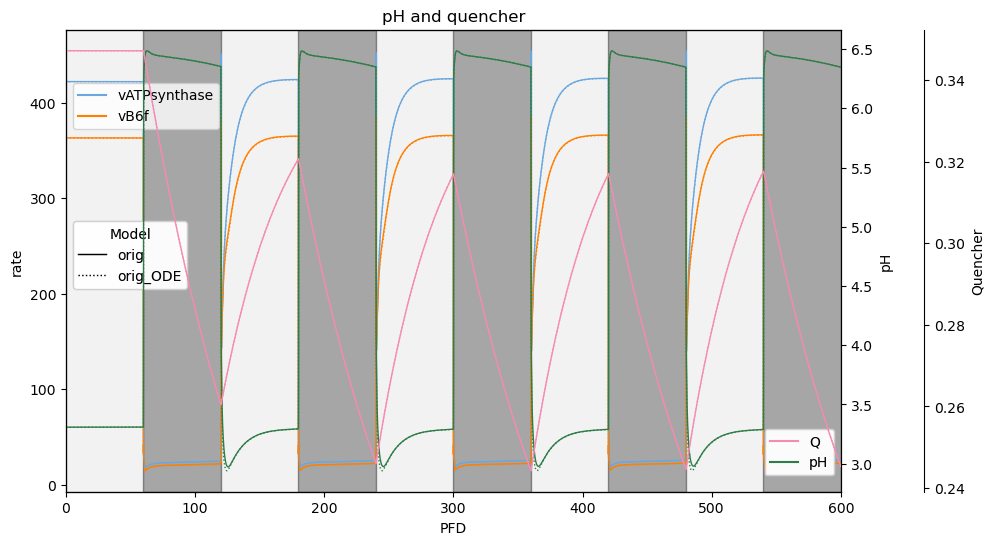

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name
        v_model = locals()[f"v_{model_name}"]  # Use locals() to access the variable by name

        ax1.plot(v_model["vATPsynthase"], label="vATPsynthase", color=colors[0], linestyle=style, lw=width)
        ax1.plot(v_model["vB6f"], label="vb6f", color=colors[1], linestyle=style, lw=width)

        ax2.plot(c_model["pH"], label="pH", color=colors[2], linestyle=style, lw=width)

        ax3.plot(c_model["Q"], label="Q", color=colors[3], linestyle=style, lw=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

shade_light(c_model, (ax1))

metabolite_handles1 = [
        Line2D([0], [0], label="vATPsynthase", color=colors[0]),
        Line2D([0], [0], label="vB6f", color=colors[1])
]
metabolite_handles2 = [
        Line2D([0], [0], label="Q", color=colors[3]),
        Line2D([0], [0], label="pH", color=colors[2]),
]

ax1.set(title="pH and quencher",
        xlabel="time (s)",
        ylabel="rate",
        xlim=(0, c_model.index[-1]),
        #xlim=(119.5, 130)
        )
ax2.set_ylabel("pH")
ax3.set_ylabel("Quencher")

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0, 0.9))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1, 0.15))
legend4 = ax1.legend(handles=model_handles, title="Model", loc="upper left", bbox_to_anchor=(0, 0.6))
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.add_artist(legend4)

fig.show()

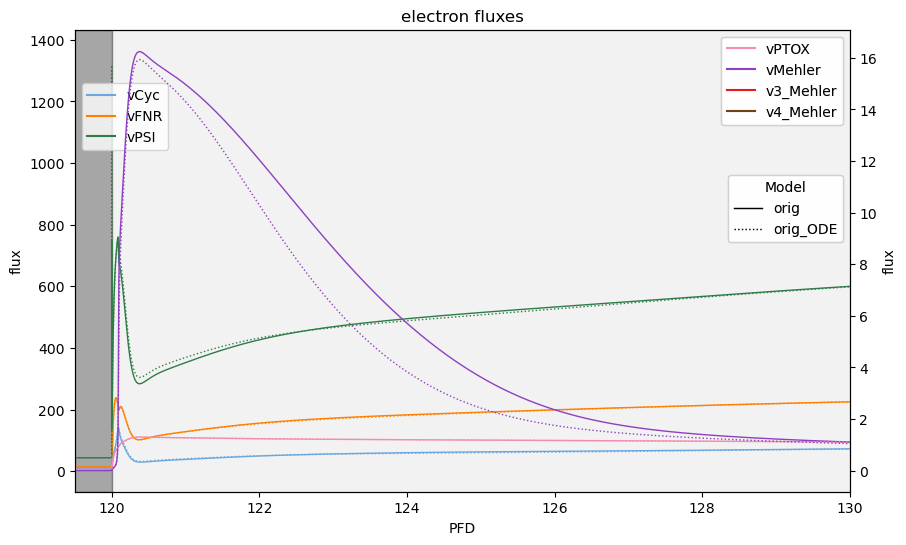

In [ ]:
# ELECTRON FLUXES

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

model_handles = []

for model_name, (style, width) in models.items():
        v_model = locals()[f"v_{model_name}"]  # Use locals() to access the variable by name
        ax1.plot(v_model["vCyc"], label="vCyc", color=colors[0], linestyle=style, lw=width)
        ax1.plot(v_model["vFNR"], label="vFNR", color=colors[1], linestyle=style, lw=width)
        ax1.plot(v_model["vPS1"], label="vPS1", color=colors[2], linestyle=style, lw=width)
        # if model_name == "orig":
        #         ax1.plot(v_model["vPS2"]*2, label="vPS2", color=colors[2], linestyle=style, lw=width)
        # else:
        #         ax1.plot(v_model["vB20"], label="vPS2", color=colors[2], linestyle=style, lw=width)

        ax2.plot(v_model["vPTOX"], label="vPTOX", color=colors[3], linestyle=style, lw=width)
        if model_name not in ["orig", "orig_ODE"]:
                ax2.plot(v_model["v3_Mehler"]+v_model["v4_Mehler"], label="vMehler", color=colors[4], linestyle=style, lw=width)
                ax2.plot(v_model["v3_Mehler"], label="v3_Mehler", color=colors[5], linestyle=style, lw=width)
                ax2.plot(v_model["v4_Mehler"], label="v4_Mehler", color=colors[6], linestyle=style, lw=width)
        else:
                ax2.plot(v_model["vMehler"], label="vMehler", color=colors[4], linestyle=style, lw=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

shade_light(c_model, (ax1))

ax1.set(title="electron fluxes",
        xlabel="time (s)",
        ylabel="flux",
        xlim=(119.5, 130)
        )
ax2.set_ylabel("flux")

metabolite_handles1 = [
        Line2D([0], [0], label="vCyc", color=colors[0]),
        Line2D([0], [0], label="vFNR", color=colors[1]),
        Line2D([0], [0], label="vPSI", color=colors[2])
]
metabolite_handles2 = [
        Line2D([0], [0], label="vPTOX", color=colors[3]),
        Line2D([0], [0], label="vMehler", color=colors[4]),
        Line2D([0], [0], label="v3_Mehler", color=colors[5]),
        Line2D([0], [0], label="v4_Mehler", color=colors[6]),
]

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0, 0.9))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1, 1))
legend4 = ax1.legend(handles=model_handles, title="Model", loc="upper right", bbox_to_anchor=(1, 0.7))
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.add_artist(legend4)

#ax2.set_yscale('log')

fig.show()


NameError: name 'models' is not defined

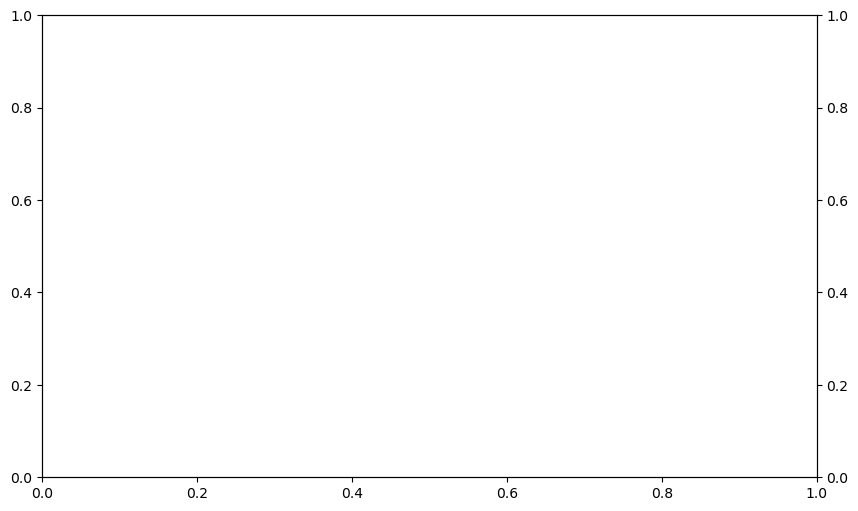

In [10]:
# Photosystem I

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()

model_handles = []

for model_name, (style, width) in models.items():
        c_model = locals()[f"c_{model_name}"]  # Use locals() to access the variable by name
        ax1.plot(c_model["P700FA"], label="P700FA", color=colors[0], linestyle=style, linewidth=width)

        ax2.plot(c_model["P700+FA"], label="P700+FA", color=colors[1], linestyle=style, linewidth=width)
        ax2.plot(c_model["P700+FA-"], label="P700+FA-", color=colors[2], linestyle=style, linewidth=width)

        model_handles.append(Line2D([0], [0], color='black', linestyle=style, lw=width, label=model_name))

shade_light(c_model, (ax1))

# Set labels and legends
ax1.set(title="Photosystem I",
        xlabel="time (s)",
        ylabel="fraction of total pool",
        xlim=(119.5, 130))
ax2.set_ylabel("fraction of total pool")

# Legends

metabolite_handles1 = [
        Line2D([0], [0], label="P700FA", color=colors[0])
]
metabolite_handles2 = [
        Line2D([0], [0], label="P700+FA", color=colors[1]),
        Line2D([0], [0], label="P700+FA-", color=colors[2]),
]

legend1 = ax1.legend(handles=metabolite_handles1, loc="upper left",  bbox_to_anchor=(0, 1))
legend2 = ax2.legend(handles=metabolite_handles2, loc="upper right", bbox_to_anchor=(1,1))
legend3 = ax1.legend(handles=model_handles,       title="Model")
ax1.add_artist(legend1)
ax2.add_artist(legend2)
ax1.legend(handles=model_handles, title="Model", loc="upper right", bbox_to_anchor=(1, 0.85))

# ax1.legend(loc="upper left", bbox_to_anchor=(0.06, 1))
# ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.2))